In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !cp /content/drive/MyDrive/DeepDiveAI-Project-2025/EmotionDataset.zip /content/
# !unzip "/content/drive/MyDrive/DeepDiveAI-Project-2025/EmotionDataset.zip" -d "/content/"
# !rm --recursive /content/EmotionDataset/
#=============================================

target_dir = "/content/EmotionDataset"

import shutil, os

if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

os.makedirs(target_dir, exist_ok=True)

!unzip "/content/drive/MyDrive/DeepDiveAI-Project-2025/EmotionDataset.zip" -d "{target_dir}"
# !unzip "/content/drive/MyDrive/DeepDiveAI-Project-2025/archive.zip" -d "{target_dir}"

Streaming output truncated to the last 5000 lines.
  inflating: /content/EmotionDataset/train/sad/im37.png  
  inflating: /content/EmotionDataset/train/sad/im370.png  
  inflating: /content/EmotionDataset/train/sad/im3700.png  
  inflating: /content/EmotionDataset/train/sad/im3701.png  
  inflating: /content/EmotionDataset/train/sad/im3702.png  
  inflating: /content/EmotionDataset/train/sad/im3703.png  
  inflating: /content/EmotionDataset/train/sad/im3704.png  
  inflating: /content/EmotionDataset/train/sad/im3705.png  
  inflating: /content/EmotionDataset/train/sad/im3706.png  
  inflating: /content/EmotionDataset/train/sad/im3707.png  
  inflating: /content/EmotionDataset/train/sad/im3708.png  
  inflating: /content/EmotionDataset/train/sad/im3709.png  
  inflating: /content/EmotionDataset/train/sad/im371.png  
  inflating: /content/EmotionDataset/train/sad/im3710.png  
  inflating: /content/EmotionDataset/train/sad/im3711.png  
  inflating: /content/EmotionDataset/train/sad/im3712

In [1]:
# Printing dataset structure (training 80% | testing 20% split)
print("Train subfolder structure\n")
train_dir = "/content/EmotionDataset/train"

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        num_files = len(os.listdir(label_path))
        print(f"{label}: {num_files} files")

print("\n========================================\n")

print("Test subfolder structure\n")
test_dir = "/content/EmotionDataset/test"

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        num_files = len(os.listdir(label_path))
        print(f"{label}: {num_files} files")

Train subfolder structure



NameError: name 'os' is not defined

In [ ]:
# import os
# os.kill(os.getpid(), 9)  # this forces runtime restart in Colab

In [4]:
import os
from PIL import Image, UnidentifiedImageError

def remove_corrupted_images(root_dir):
    extensions = ['.jpg', '.jpeg', '.png']
    removed_files = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in extensions:
                file_path = os.path.join(subdir, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify that it is, indeed an image
                except (UnidentifiedImageError, OSError) as e:
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)
                    removed_files.append(file_path)

    print(f"Total corrupted images removed: {len(removed_files)}")

# Call it on your dataset path (test and train folders)
remove_corrupted_images('/content/EmotionDataset/train')
remove_corrupted_images('/content/EmotionDataset/test')


Total corrupted images removed: 0
Total corrupted images removed: 0


In [5]:
# image_loader.py
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset, random_split, DataLoader
import timm
from torchvision.datasets import ImageFolder

def get_image_dataloaders(dataset_path, batch_size, num_workers, loadNumImages=-1, model_name='resnet50.a1_in1k'):
    if model_name == 'custom':
        # Use basic transforms for custom CNN
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])
    elif model_name in timm.list_models() or model_name in timm.list_models(pretrained=True):
        # Load model-specific transform
        model = timm.create_model(model_name, pretrained=True, num_classes=0)
        data_config = timm.data.resolve_model_data_config(model)
        # transform = timm.data.create_transform(**data_config, is_training=False)
        # train_transform = timm.data.create_transform(**data_config, is_training=True)
        # test_transform = timm.data.create_transform(**data_config, is_training=False)

        # In image_loader.py
        # train_transform = transforms.Compose([
        #     transforms.Lambda(lambda img: img.convert("RGB")),
        #     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.ToTensor(),
        #     transforms.Normalize(data_config['mean'], data_config['std']),
        # ])

        # train_transform = transforms.Compose([
        #     transforms.Lambda(lambda img: img.convert("RGB")),
        #     transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
        #     transforms.RandomHorizontalFlip(p=0.5),
        #     transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
        #     transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(data_config['mean'], data_config['std']),
        # ])

        train_transform = transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
                transforms.RandomAffine(20, translate=(0.15, 0.15), scale=(0.8, 1.2)),
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(data_config['mean'], data_config['std']),
            transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), value='random'),
        ])

        test_transform = transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize(224),  # Changed from 256
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(data_config['mean'], data_config['std']),
        ])

    else:
        return ValueError("Model not found")

    def limit_dataset(dataset):
        if loadNumImages <= 0:
            return dataset

        # Ensure balanced sampling
        class_counts = {i: 0 for i in range(len(dataset.classes))}
        indices = []

        for idx, (_, label_idx) in enumerate(dataset.samples):
            if class_counts[label_idx] < loadNumImages:
                indices.append(idx)
                class_counts[label_idx] += 1

        return Subset(dataset, indices)

    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

    train_dataset = limit_dataset(train_dataset)
    test_dataset = limit_dataset(test_dataset)

    pin = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)

    return train_loader, test_loader


In [ ]:
# import timm
# timm.list_models()
# import timm
# if 'vit_base_patch16_224.augreg_in21k' in timm.list_models(pretrained=True):
#   print(True)

# # Search for matching models
# models = timm.list_models("vit_base_patch16_224*", pretrained=True)
# print(models)

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit3_base_patch16_224',
 'beit3_giant_patch14_224',
 'beit3_giant_patch14_336',
 'beit3_large_patch16_224',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_sma

In [ ]:
# import timm
# if 'vit_base_patch16_224.augreg_in21k' in timm.list_models(pretrained=True):
#   print(True)

# # Search for matching models
# models = timm.list_models("vit_base_patch16_224*", pretrained=True)
# print(models)

True
['vit_base_patch16_224.augreg2_in21k_ft_in1k', 'vit_base_patch16_224.augreg_in1k', 'vit_base_patch16_224.augreg_in21k', 'vit_base_patch16_224.augreg_in21k_ft_in1k', 'vit_base_patch16_224.dino', 'vit_base_patch16_224.mae', 'vit_base_patch16_224.orig_in21k', 'vit_base_patch16_224.orig_in21k_ft_in1k', 'vit_base_patch16_224.sam_in1k', 'vit_base_patch16_224_miil.in21k', 'vit_base_patch16_224_miil.in21k_ft_in1k']


In [17]:
# trainer.py
import os, torch
import torch.nn as nn
import torch.nn.functional as F
# from model import EmotionNet # UNCOMMENT IN VSCODE
from tqdm import tqdm
import pandas as pd
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import balanced_accuracy_score

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
# from model import MoodCNN  # <- this is the custom model, no timm

class Trainer:
    def __init__(self, args, train_loader=None, epoch=1):
        self.args = args
        # self.epoch = args.epochs
        self.epoch = epoch

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if args.model_name == 'custom':
            self.model = MoodCNN2(num_classes=args.num_classes).to(self.device)
        elif args.model_name == 'resnet50.a1_in1k':
            backbone = timm.create_model(args.model_name, pretrained=True, num_classes=0)
            self.model = EmotionNet(backbone, args.num_classes).to(self.device)
        elif args.model_name.startswith("google/vit"): #Idk why it's this
            from transformers import ViTForImageClassification
            self.model = ViTForImageClassification.from_pretrained(
                args.model_name,
                num_labels=args.num_classes,
                ignore_mismatched_sizes=True
            ).to(self.device)
        elif args.model_name in timm.list_models(pretrained=True):
            backbone = timm.create_model(args.model_name, pretrained=True, num_classes=0)
            self.model = EmotionNet(backbone, args.num_classes).to(self.device)
        else:
            raise ValueError("Model not found")

        # Penalize or reward model using weights. Higher weights means that label is underrepresented, and is not as easily to generalize on new data.
        weights_array = {
            0: 1.0,   # neutral
            1: 1.6,   # sad
            2: 0.5,   # happy (overrepresented)
            3: 1.6,   # angry
            4: 1.1,   # fearful
            5: 1.3,   # surprised
            6: 1.7,   # disgusted (rare)
        }
        # Convert to tensor
        self.class_weights = torch.tensor([weights_array[i] for i in range(len(weights_array))], dtype=torch.float32).to(self.device)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=args.lr_decay)
        # self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.epochs)
        # self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs)
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        # self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


        # Logging DataFrame
        self.logs_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy", "F1 Score"])

    def get_class_weights(self):
        return self.class_weights

    def train_network(self, epoch, loader, **kwargs):
        self.model.train()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(loader, desc=f"Epoch {epoch} [Training]", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(self.device), labels.to(self.device)

            outputs = self.model(imgs)
            loss = self.criterion(outputs, labels)

            # print("Softmax output:", torch.softmax(outputs, dim=1)[0].detach().cpu().numpy())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item())

        self.scheduler.step()
        avg_loss = total_loss / len(loader)
        accuracy = (correct / total) * 100.0
        return avg_loss, accuracy, self.optimizer.param_groups[0]['lr']

    def get_classes(self, dataset):
        while hasattr(dataset, 'dataset'):
            dataset = dataset.dataset
        return getattr(dataset, 'classes', None)

    def evaluate_network(self, epoch=0, loader=None, **kwargs):
        self.model.eval()
        #for avg_loss and accuracy
        correct, total, total_loss = 0, 0, 0

        #for f1 score
        all_preds, all_labels = [], []

        loop = tqdm(loader, desc=f"Epoch {epoch} [Evaluating]", leave=False)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)

                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                total_loss += loss.item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                #Unweighted accuracy so it's faster
                loop.set_postfix(accuracy=f"{(correct/total)*100:.2f}%")

        avg_loss = total_loss / len(loader)
        # accuracy = (correct / total) * 100.0
        sample_weights = np.array([self.class_weights.cpu().numpy()[label] for label in all_labels])

        weighted_acc = accuracy_score(all_labels, all_preds, sample_weight=sample_weights) * 100.0
        # balanced_acc = balanced_accuracy_score(all_labels, all_preds) * 100.0
        f1 = f1_score(all_labels, all_preds, average='weighted') * 100.0

        # Add confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        classes = self.get_classes(loader.dataset)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes,
                    yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return avg_loss, weighted_acc, f1

    def log_metrics(self, epoch, train_loss, train_acc, val_loss, val_acc, f1):
        new_row = {
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Val Loss": val_loss,
            "Val Accuracy": val_acc,
            "F1 Score": f1
        }
        self.logs_df = pd.concat([self.logs_df, pd.DataFrame([new_row])], ignore_index=True)
        display(self.logs_df.tail(10))  # display last 10 entries for readability in Colab

    def plot_metrics(self):
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Plot Loss (Train + Validation)
        axes[0].set_title(f"Model Loss - {self.args.model_name}", fontsize=14)
        sns.lineplot(ax=axes[0], x="Epoch", y="Train Loss", data=self.logs_df, label="Train Loss", marker="o")
        sns.lineplot(ax=axes[0], x="Epoch", y="Val Loss", data=self.logs_df, label="Val Loss", marker="o")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        # Plot Accuracy + F1
        axes[1].set_title(f"Accuracy & F1 Score - {self.args.model_name}", fontsize=14)
        sns.lineplot(ax=axes[1], x="Epoch", y="Train Accuracy", data=self.logs_df, label="Train Accuracy", marker="o")
        sns.lineplot(ax=axes[1], x="Epoch", y="Val Accuracy", data=self.logs_df, label="Val Accuracy", marker="o")
        sns.lineplot(ax=axes[1], x="Epoch", y="F1 Score", data=self.logs_df, label="F1 Score", marker="o")

        # Highlight max points
        max_acc_idx = self.logs_df["Val Accuracy"].idxmax()
        max_f1_idx = self.logs_df["F1 Score"].idxmax()
        acc_x = self.logs_df.loc[max_acc_idx, "Epoch"]
        acc_y = self.logs_df.loc[max_acc_idx, "Val Accuracy"]
        f1_x = self.logs_df.loc[max_f1_idx, "Epoch"]
        f1_y = self.logs_df.loc[max_f1_idx, "F1 Score"]

        axes[1].plot(acc_x, acc_y, "ro")
        axes[1].text(acc_x, acc_y + 0.5, f"Max Val Acc: {acc_y:.2f}%", color="red")

        axes[1].plot(f1_x, f1_y, "go")
        axes[1].text(f1_x, f1_y + 0.5, f"Max F1: {f1_y:.2f}%", color="green")

        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Score (%)")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def saveParameters(self, path):
        torch.save(self.model.state_dict(), path)

    def loadParameters(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))


In [13]:
# model.py
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from urllib.request import urlopen
import timm

from tqdm import tqdm
import time

#Using pretrained resnet50.a1_in1k model as a feature extractor, without classifier head
# backbone_model = timm.create_model(
#     'resnet50.a1_in1k',
#     pretrained=True,
#     num_classes = 0,
# )

# effNet = timm.create_model(
#     "efficientnetv2_m.in21k_ft_in1k",
#     pretrained=True,
#     num_classes = 0
# )

#Vision Transformer for > 5k images
# backbone_model = timm.create_model(
#     'google/vit_base_patch16_224',
#     pretrained=True,
#     num_classes = 0,
# )

#ViT pretrained on 14 million images
# backbone_model = timm.create_model(
#     'vit_base_patch16_224_in21k',
#     pretrained=True,
#     num_classes = 0,
# )

# backbone_model = timm.create_model(
#     'vit_base_patch16_224.augreg_in21k',
#     pretrained=True,
#     num_classes = 0,
# )

#============================================
models = [
    'resnet50.a1_in1k', # Used multiple times, got max 67% accuracy
    'efficientnetv2_m.in21k_ft_in1k', #Never tested
    'vit_base_patch16_224_in21k', # Deprecated
    'google/vit_base_patch16_224', #used once, got 72.14% accuracy
    'vit_base_patch16_224.augreg_in21k' #Testing now
]

model_name = models[4]
num_classes = 7
print(model_name)

#STEPS
# 1) List initial distributions of each emotion from the original data  DONE
# 2) Use sklearn for f1 score and weighted accuracy  DONE
# 3) Find the predictions for each label and see which one is the worst and best. Consider removing the one label that performs the worst. ??? Working on implementing penalizing weights for class labels


class MoodCNN1(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(MoodCNN1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Increase capacity and add residual connections
class MoodCNN2(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(MoodCNN2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128)
        )

        self.conv2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        res = x
        x = self.res1(x)
        x += F.interpolate(res, scale_factor=1, mode='nearest')  # Skip connection
        x = self.conv2(x)
        res = x
        x = self.res2(x)
        x += res  # Skip connection
        return self.classifier(x)


class EmotionNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(EmotionNet, self).__init__()

        # The pretrained Vision Transformer (ViT) feature extractor model used
        self.backbone = backbone

        # MLP classifier head to categorize the input features to 7 unique output logits
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(backbone.num_features),
            nn.Dropout(0.5),
            nn.Linear(backbone.num_features, 512),
            nn.SiLU(inplace=True),  # Better activation than ReLU (Sigmoid Linear Unit)
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    # Forward Pass
    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

vit_base_patch16_224.augreg_in21k


In [14]:
# Define global persistent path to save best.model
GLOBAL_MODEL_PATH = "/content/drive/MyDrive/emotion_model/best.model"
GLOBAL_SCORE_PATH = "/content/drive/MyDrive/emotion_model/score.txt"

# Patch in a persistent model path default (global best model)
def get_best_model_path():
    return GLOBAL_MODEL_PATH

def get_best_score_path():
    return GLOBAL_SCORE_PATH

In [15]:
import argparse, sys

def get_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--model_name', type=str, default=model_name, help="Backbone model name from timm")
    parser.add_argument('--num_classes', type=int, default=num_classes, help="Number of emotion classes")
    parser.add_argument("--loadNumImages", type=int, default=-1, help="Max images to load per class. Use -1 to load all.")
    parser.add_argument('--batch_size', type=int, default=64) # higher means higher learning rate
    parser.add_argument('--num_workers', type=int, default=2) #4 is too much for google colab to handle
    # parser.add_argument('--lr', type=float, default=1e-3) #FOR RESNET50
    parser.add_argument('--lr', type=float, default=2e-5) # FOR GOOGLE/VIT
    parser.add_argument('--lr_decay', type=float, default=0.95)
    parser.add_argument('--weight_decay', type=float, default=1e-3)
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--dataset_path', type=str, default='/content/EmotionDataset')
    parser.add_argument('--savePath', type=str, default='checkpoints')
    parser.add_argument('--testInterval', type=int, default=1)
    parser.add_argument('--evaluation', action='store_true')
    parser.add_argument('--eval_model_path', type=str, default=get_best_model_path())
    parser.add_argument('--freeze_params', type=bool, default=True)
    parser.add_argument('--resume', type=bool, default=True, help="If true, resume from best model checkpoint in Google Drive") #ONLY ONE OF THESE TWO SHOULD BE TRUE
    parser.add_argument('--restart', type=bool, default=False, help="If true, restart the whole training with the current model")

    # Check if we're in an interactive environment like Colab
    if hasattr(sys, 'ps1') or 'ipykernel' in sys.modules:
        return parser.parse_args(args=[])
    else:
        return parser.parse_args()


Epoch 30 [Training]: 100%|██████████| 449/449 [06:44<00:00,  1.27it/s, loss=0.379]
                                                                                  
Epoch 30 [Evaluating]:   0%|          | 0/113 [00:37<?, ?it/s, accuracy=72.11%]

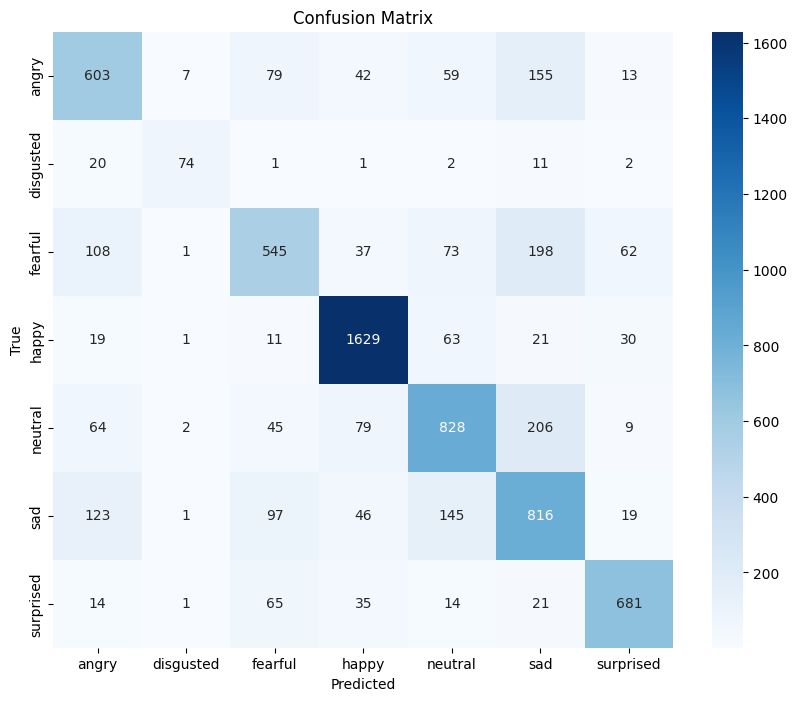

2025-07-31 03:53:21 30 epoch, LR 0.000017, LOSS 0.2296, Val Acc 69.89%, F1 71.96%, Best Acc 77.10%



Epoch 31 [Training]: 100%|██████████| 449/449 [06:44<00:00,  1.27it/s, loss=0.307]
                                                                                  
Epoch 31 [Evaluating]:   0%|          | 0/113 [00:37<?, ?it/s, accuracy=72.69%]

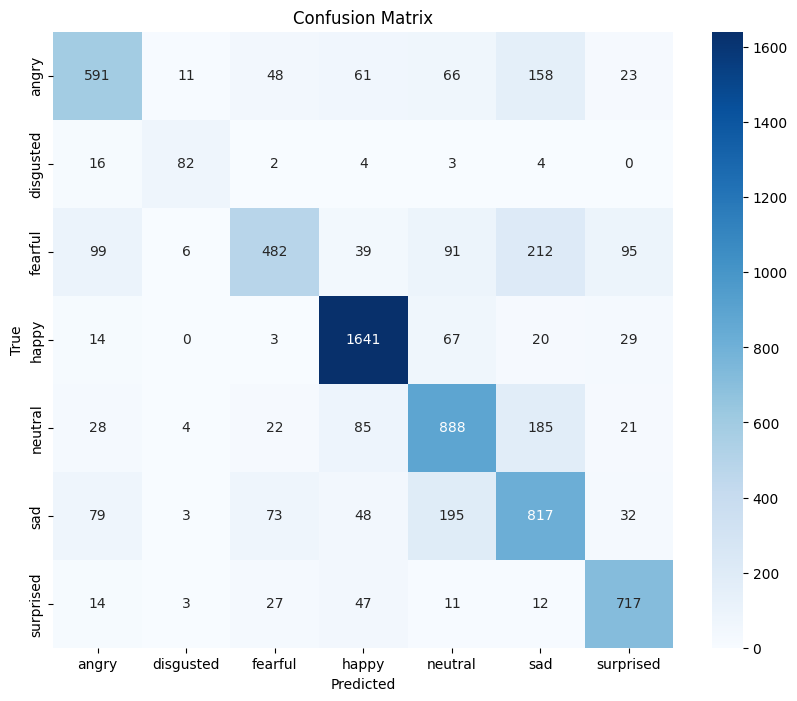

2025-07-31 04:00:44 31 epoch, LR 0.000016, LOSS 0.2154, Val Acc 71.28%, F1 72.17%, Best Acc 77.10%



Epoch 32 [Training]: 100%|██████████| 449/449 [06:44<00:00,  1.27it/s, loss=0.157]
                                                                                  
Epoch 32 [Evaluating]:   0%|          | 0/113 [00:37<?, ?it/s, accuracy=72.07%]

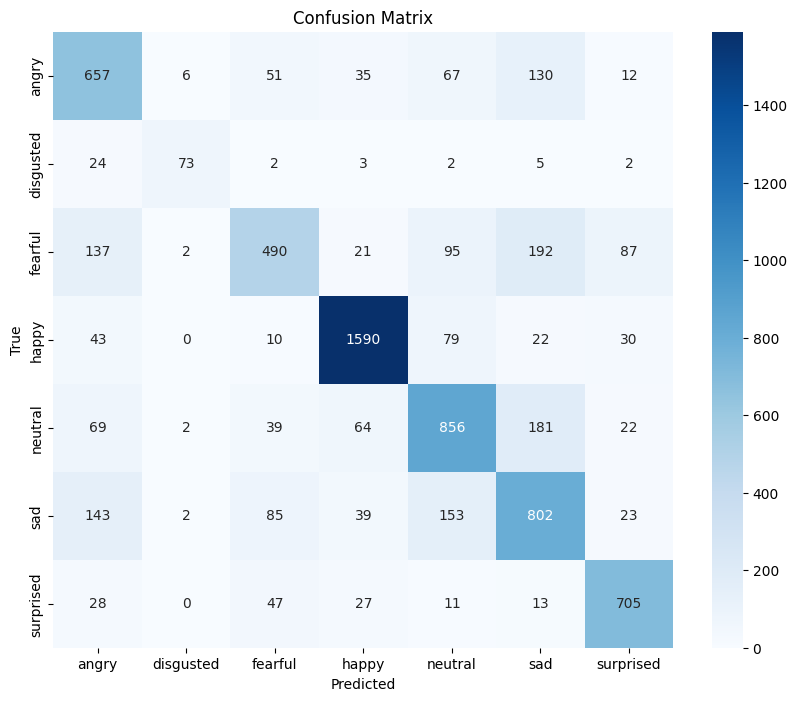

2025-07-31 04:08:06 32 epoch, LR 0.000015, LOSS 0.2010, Val Acc 70.06%, F1 71.85%, Best Acc 77.10%


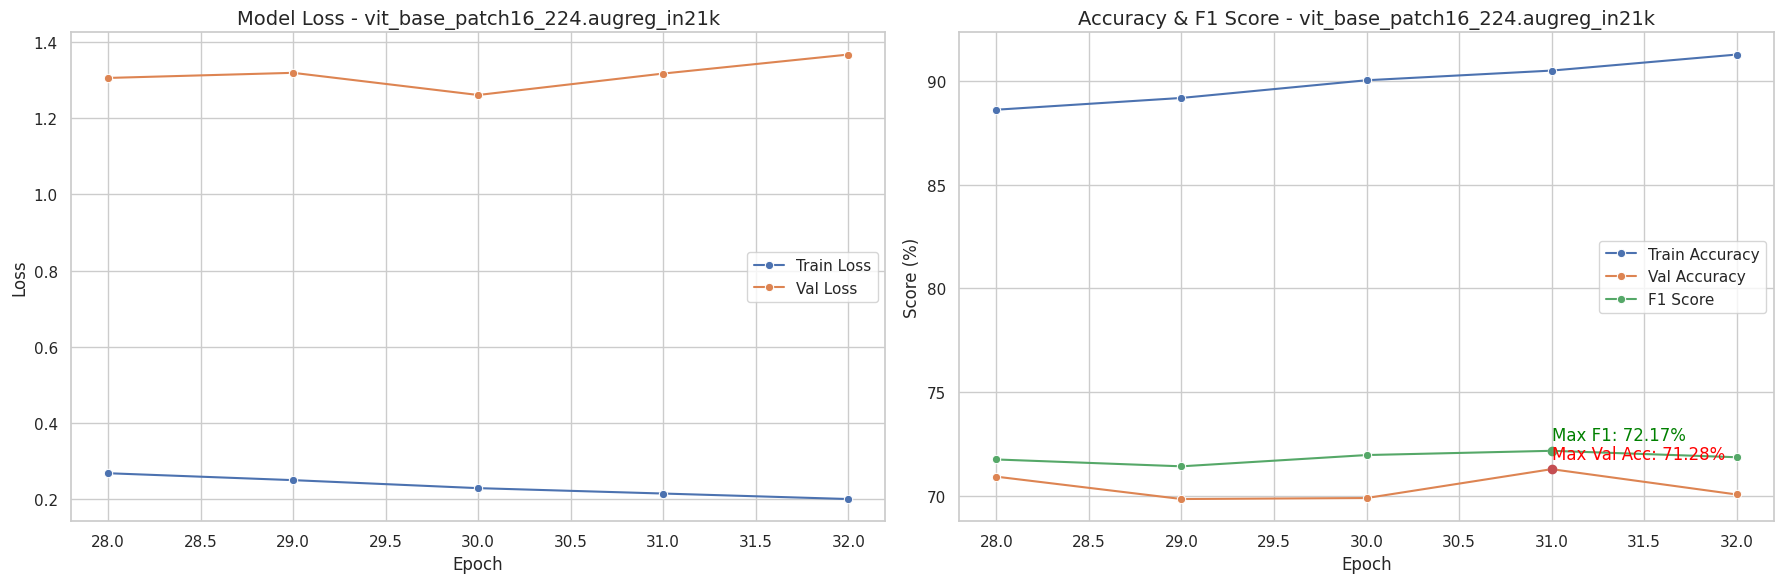

In [16]:
# main.py
import os, glob, time
# from trainer import Trainer # UNCOMMENT IN VSCODE
# from image_loader import get_image_dataloaders # UNCOMMENT IN VSCODE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from IPython.display import display, clear_output

def get_last_best_accuracy(score_path):
    try:
        if os.path.exists(score_path):
            with open(score_path, "r") as f:
                lines = f.readlines()
                if lines:
                    last_line = lines[-1]
                    for part in last_line.strip().split(","):
                        if "Best Acc" in part:
                            return float(part.strip().split(" ")[-1].replace("%", ""))
    except Exception as e:
        print("Error reading previous best accuracy:", e)
    return 0

def replace_file(source_file_path, destination_file_path):
    """
    Replaces the content of a destination text file with the content of a source text file.

    Args:
        source_file_path (str): The path to the source text file.
        destination_file_path (str): The path to the destination text file to be replaced.
    """
    try:
        # Copy the content of the source file to the destination file.
        # This will overwrite the destination file if it exists.
        shutil.copy2(source_file_path, destination_file_path)
        print(f"'{destination_file_path}' successfully replaced with '{source_file_path}'.")
    except FileNotFoundError:
        print(f"Error: One of the files was not found. Source: '{source_file_path}', Destination: '{destination_file_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")

def get_last_epoch(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Remove empty lines and strip whitespace
    lines = [line.strip() for line in lines if line.strip()]

    if not lines:
        return 0  # File is empty

    last_line = lines[-1]
    try:
        epoch_str = last_line.split()[0]
        return int(epoch_str)
    except (IndexError, ValueError):
        return 0



def main(args):
    # print(args.model_name)
    trainLoader, valLoader = get_image_dataloaders(
        dataset_path=args.dataset_path,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        loadNumImages=args.loadNumImages,
        model_name=args.model_name
    )

    if args.evaluation:
        s = Trainer(args, trainLoader)

        # Auto-load best.model if no eval_model_path is explicitly set
        if args.eval_model_path == "path not specified":
            best_model_path = os.path.join(args.savePath, "model", "best.model")
            if os.path.exists(best_model_path):
                args.eval_model_path = best_model_path
                print(f"Auto-loading best model from {args.eval_model_path}")
            else:
                print("Evaluation model path not specified and best.model does not exist.")
                return

        s.loadParameters(args.eval_model_path)
        print("Parameters loaded from path", args.eval_model_path)

    args.modelSavePath = os.path.join(args.savePath, 'model')
    os.makedirs(args.modelSavePath, exist_ok=True)
    args.scoreSavePath = os.path.join(args.savePath, 'score.txt')


    # If resume is explicitly requested, load from best.model in Google Drive
    if args.resume:
        epoch = 1
        initial_epoch = get_last_epoch(GLOBAL_SCORE_PATH)
        s = Trainer(args, trainLoader, epoch=epoch)
        best_model_path = GLOBAL_MODEL_PATH
        if os.path.exists(best_model_path):
            print(f"Resuming from best model: {best_model_path}")
            s.loadParameters(best_model_path)
            #update score file
            replace_file(GLOBAL_SCORE_PATH, args.scoreSavePath)
        else:
            print(f"Resume requested, but model not found at: {best_model_path}. Starting from scratch.")
    else:

        modelfiles = glob.glob('%s/model_0*.model' % args.modelSavePath)
        # modelfiles += glob.glob(f'{args.modelSavePath}/best.model')  # Add this line
        modelfiles.sort()

        if len(modelfiles) >= 1 and not args.restart:
            print("Model %s loaded from previous state!" % modelfiles[-1])
            epoch = 1
            initial_epoch = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][6:])
            s = Trainer(args, trainLoader, epoch=initial_epoch+1)
            s.loadParameters(modelfiles[-1])
        else:
            epoch = 1
            initial_epoch = 0
            s = Trainer(args, trainLoader, epoch=epoch)
            print("Starting training from scratch")


    mAPs = []

    bestmAP = get_last_best_accuracy(args.scoreSavePath)
    scoreFile = open(args.scoreSavePath, "a+")
    print(bestmAP, "LAST BEST ACCURACYY!!")
    while epoch <= args.epochs:
        new_epoch = epoch + initial_epoch

        train_loss, train_acc, lr = s.train_network(epoch=new_epoch, loader=trainLoader)

        if new_epoch % args.testInterval == 0:
            val_loss, val_acc, val_f1 = s.evaluate_network(epoch=new_epoch, loader=valLoader)
            mAP = val_acc  # use validation accuracy as "mAP" proxy
            mAPs.append(mAP)

            # Log metrics to dataframe
            s.logs_df.loc[len(s.logs_df)] = {
                "Epoch": new_epoch,
                "Train Loss": train_loss,
                "Train Accuracy": train_acc,
                "Val Loss": val_loss,
                "Val Accuracy": val_acc,
                "F1 Score": val_f1
            }

            # Save every epoch's model with a numbered name
            s.saveParameters(f"{args.modelSavePath}/model_{new_epoch:04d}.model")

            if mAP > bestmAP:
                bestmAP = mAP
                #write results to the local score.txt
                scoreFile.write(
                    f"{new_epoch} epoch, LR {lr:.6f}, LOSS {train_loss:.4f}, "
                    f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.2f}%, F1 {val_f1:.2f}%, Best Acc {bestmAP:.2f}%\n"
                )
                scoreFile.flush()
                # s.saveParameters(f"{args.modelSavePath}/best.model")
                best_model_path_local = f"{args.modelSavePath}/best.model"
                s.saveParameters(best_model_path_local)

                # Define Google Drive upload path
                drive_model_path = GLOBAL_MODEL_PATH

                # Upload to Google Drive only if improved
                os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)
                from shutil import copyfile
                #Update the model in google drive
                copyfile(best_model_path_local, drive_model_path)
                #Update score.txt in google drive
                copyfile(args.scoreSavePath, GLOBAL_SCORE_PATH)

                print(f"New best model copied to Google Drive at {drive_model_path}")

            else:
                #write results to the local score.txt
                scoreFile.write(
                    f"{new_epoch} epoch, LR {lr:.6f}, LOSS {train_loss:.4f}, "
                    f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.2f}%, F1 {val_f1:.2f}%, Best Acc {bestmAP:.2f}%\n"
                )
                scoreFile.flush()

            print(time.strftime("%Y-%m-%d %H:%M:%S"),
                  f"{new_epoch} epoch, LR {lr:.6f}, LOSS {train_loss:.4f}, "
                  f"Val Acc {val_acc:.2f}%, F1 {val_f1:.2f}%, Best Acc {bestmAP:.2f}%")


        epoch += 1

    scoreFile.close()
    s.plot_metrics()


if __name__ == "__main__":
    args = get_args()
    main(args)


In [19]:
# COMPRESS BEST MODEL's linear layers' features using quantization, updating the file in google drive directly

import torch
# from model import EmotionNet
import timm

# Load backbone as used in EmotionNet
backbone = timm.create_model(
    'vit_base_patch16_224.augreg_in21k',
    pretrained=False,
    num_classes=0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create and load the model
model = EmotionNet(backbone=backbone, num_classes=7)
model.load_state_dict(torch.load("/content/drive/MyDrive/emotion_model/best.model", map_location=device))
model.eval()

# Apply dynamic quantization to Linear layers
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Save the quantized model
torch.save(quantized_model.state_dict(), "best_model_quantized.pth")

import shutil
shutil.copyfile("best_model_quantized.pth", "/content/drive/MyDrive/emotion_model/best_model_quantized.pth")

'/content/drive/MyDrive/emotion_model/best_model_quantized.pth'

In [20]:
# script to predict emotion of a person from the source link of an image
import torch
import requests
from PIL import Image
from torchvision import transforms
# from model import EmotionNet, MoodCNN2  # UNCOMMENT IN VSCODE
import timm
import io

prediction_args = {
    # "model_type": 'resnet50.a1_in1k',
    # "model_type": 'google/vit_base_patch16_224',
    # 'model_type': 'vit_base_patch16_224.augreg_in21k',
    'model_type': model_name,
    "checkpoint_path": GLOBAL_MODEL_PATH,
    "class_names": ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
}

# Load model (same constructor and checkpoint path)
# (Moved this part of code to the outside to speed it up)
model = timm.create_model(prediction_args['model_type'], pretrained=True, num_classes=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = timm.create_model(prediction_args['model_type'], pretrained=False, num_classes=0)
model = EmotionNet(backbone, num_classes=len(prediction_args['class_names']))
model.load_state_dict(torch.load(prediction_args['checkpoint_path'], map_location=device))
model.to(device)
model.eval()

def predict_from_url(
    url
):
    # Download and open image
    response = requests.get(url)

    # Turn image into black and white
    image = Image.open(io.BytesIO(response.content)).convert('L')

    data_config = timm.data.resolve_model_data_config(model)

    # Apply same transform as validation
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize(224),  # Changed from 256
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_config['mean'], data_config['std']),
    ])

    # add batch dimension
    image_tensor = transform(image).unsqueeze(0)

    # Inference
    with torch.no_grad():
        output = model(image_tensor.to(device))
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, dim=1)
        predicted_label = prediction_args['class_names'][predicted.item()]

    print(f"Predicted Emotion: {predicted_label} ({confidence.item():.2f})")
    # print(probs)
    return predicted_label, confidence.item()


In [21]:
#Correct
predict_from_url("https://t4.ftcdn.net/jpg/00/56/93/53/360_F_56935312_NiqxkRKOdGSJd86Tc2uLycL9fkUsIlRW.jpg")
predict_from_url("https://t4.ftcdn.net/jpg/00/88/53/89/360_F_88538986_5Bi4eJ667pocsO3BIlbN4fHKz8yUFSuA.jpg")
predict_from_url("https://www.pngall.com/wp-content/uploads/2/Angry-Person-Transparent.png")
predict_from_url("https://images.squarespace-cdn.com/content/v1/5d1ae7b443a4be0001f321b6/c963ccdf-eaea-492f-ae6e-49b35cef0b22/PersonCentred+Psychology.JPG")
predict_from_url("https://t4.ftcdn.net/jpg/00/73/24/39/360_F_73243993_WfQ6CwwVbsSf36W0oLaCseTecG6dQMFm.jpg")
predict_from_url("https://speakingofsuicide.com/wp-content/uploads/2013/05/angry-asking-about-suicide.jpg")

#Incorrect | All should be Angry
predict_from_url("https://www.pngmart.com/files/7/Angry-Person-Transparent-PNG.png")

#Incorrect | All should be Sad
predict_from_url("https://previews.123rf.com/images/bowie15/bowie151310/bowie15131000025/22757028-sad-man.jpg")
predict_from_url("https://photos.peopleimages.com/picture/202304/2774670-sad-business-man-and-black-worker-portrait-of-depressed-face-with-sadness-from-work.-png-background-isolated-and-professional-model-person-disappointed-of-corporate-job-fail-or-mistake-in-studio-fit_400_400.jpg")
predict_from_url("https://thumbs.dreamstime.com/z/human-expressions-emotions-young-attractive-man-sad-face-looking-depressed-unhappy-close-up-portrait-handsome-crying-139799701.jpg")
predict_from_url("https://media.istockphoto.com/id/1226482943/photo/portrait-of-a-girl-of-8-years-old-crying-and-sad.jpg?s=612x612&w=is&k=20&c=fWanbxdPn4feWGn9CnSosMYHxF-vuUCOwB4T6gYnq9o=")


predict_from_url("https://media.istockphoto.com/id/1042412136/photo/african-american-man-with-beard-feeling-disgusted-with-tongue-out.jpg?s=612x612&w=0&k=20&c=FUpiDNjUaw9EnCMUQGPPe4Bdt0LoitdRUoP6Eptb3LA=")
predict_from_url("https://media.istockphoto.com/id/174868744/photo/young-woman-making-a-disgusting-face-expression.jpg?s=612x612&w=0&k=20&c=2OqcMN-Qhc8rkj3UtNiS0tm0IpPUemr3QlGu8lerqwA=")
predict_from_url("https://t4.ftcdn.net/jpg/00/77/05/41/360_F_77054143_EiTnnNIZHWbSeSQgVEtTSSqQriOzcHEh.jpg")

# Predicted Emotion: angry (0.97)
# Predicted Emotion: happy (1.00)
# Predicted Emotion: angry (0.98)
# Predicted Emotion: angry (0.65)
# Predicted Emotion: angry (0.59)
# Predicted Emotion: sad (0.32)
# Predicted Emotion: happy (0.81)
# ('happy', 0.8105629086494446)

# Predicted Emotion: angry (0.76)
# Predicted Emotion: happy (0.61)
# Predicted Emotion: angry (1.00)
# Predicted Emotion: angry (1.00)
# Predicted Emotion: angry (1.00)
# Predicted Emotion: neutral (0.97)
# Predicted Emotion: angry (0.50)
# ('angry', 0.5021551847457886)

Predicted Emotion: angry (0.99)
Predicted Emotion: happy (0.99)
Predicted Emotion: angry (1.00)
Predicted Emotion: angry (0.87)
Predicted Emotion: angry (0.92)
Predicted Emotion: angry (1.00)
Predicted Emotion: angry (0.82)
Predicted Emotion: neutral (0.93)
Predicted Emotion: disgust (0.43)
Predicted Emotion: fear (0.79)
Predicted Emotion: sad (0.86)
Predicted Emotion: angry (1.00)
Predicted Emotion: angry (0.37)
Predicted Emotion: angry (0.89)


('angry', 0.8918254375457764)

# **Running Live Camera Emotion Prediction Using MTCNN**

In [22]:
# Installing facenet-torch WILL spit out an ERROR. If so, just continue, do not restart runtime. CLICK CONTINUE

# Restart session
# WARNING: The following packages were previously imported in this runtime:
#   [numpy,torch,torchgen,torchvision,triton]
# You must restart the runtime in order to use newly installed versions.

# Restarting will lose all runtime state, including local variables.

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.2.2 which is incompatible.
# thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
# opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
# opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
# opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
# Successfully installed Pillow-10.2.0 facenet-pytorch-2.6.0 numpy-1.26.4 nvidia-cublas-cu12-12.1.3.1 nvidia-cuda-cupti-cu12-12.1.105 nvidia-cuda-nvrtc-cu12-12.1.105 nvidia-cuda-runtime-cu12-12.1.105 nvidia-cudnn-cu12-8.9.2.26 nvidia-cufft-cu12-11.0.2.54 nvidia-curand-cu12-10.3.2.106 nvidia-cusolver-cu12-11.4.5.107 nvidia-cusparse-cu12-12.1.0.106 nvidia-nccl-cu12-2.19.3 nvidia-nvtx-cu12-12.1.105 torch-2.2.2 torchvision-0.17.2 triton-2.2.0
# WARNING: The following packages were previously imported in this runtime:
#   [numpy,torch,torchgen,torchvision,triton]
# You must restart the runtime in order to use newly installed versions.

import cv2
!pip install ultralytics
!pip install facenet-pytorch
from facenet_pytorch import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

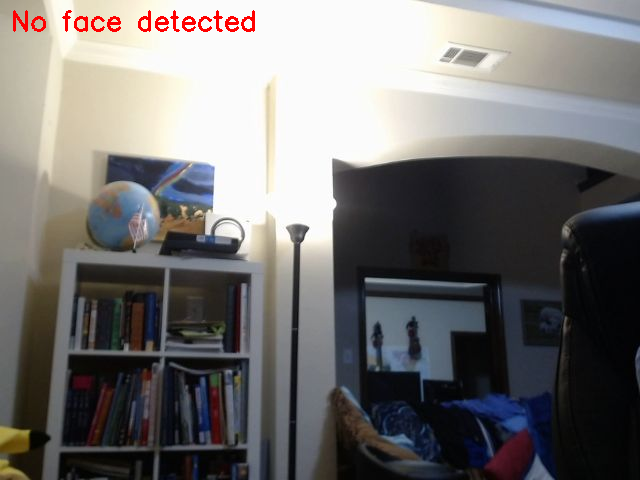

In [25]:
#camera_colab.py
import base64
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms
from IPython.display import display, Javascript, update_display, Image as IPyImage
from google.colab.output import register_callback, eval_js
import io
import time

display_id = None

class EmotionDetector:
    def __init__(self, model_type=prediction_args['model_type'], checkpoint_path = get_best_model_path(), num_classes=7, verbose=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

        # Initialize MTCNN face detector
        self.mtcnn = MTCNN(
            keep_all=True,
            min_face_size=40,
            thresholds=[0.6, 0.7, 0.7],
            device=self.device
        )

        self.model = self._load_model(model_type, checkpoint_path, num_classes)
        self.transform = self._get_transform(model_type)
        self.verbose = verbose

        self.predictions_store = {}
        self.confidence_avg = {}

    def add(self, label, loc, val):
        if label not in loc:
            loc[label] = val
        else:
            loc[label] += val

    def get_frequent_prediction(self):
        if not self.predictions_store:
            return None

        # Find label with max count
        most_frequen_emotion = max(self.predictions_store.items(), key=lambda x: x[1])[0]

        # Compute average confidence for that label
        avg_confidence = self.confidence_avg.get(most_frequen_emotion, 0) / self.predictions_store[most_frequen_emotion]

        return {'prediction': most_frequen_emotion, 'confidence': avg_confidence}

    def _load_model(self, model_type, checkpoint_path, num_classes):
        if model_type == 'resnet50.a1_in1k' or model_type.startswith("google/vit") or model_type in timm.list_models() or model_type in timm.list_models(pretrained=True):
            backbone = timm.create_model(model_type, pretrained=True, num_classes=0)
            model = EmotionNet(backbone, num_classes)
        else:
            model = MoodCNN2(num_classes=num_classes)

        model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        return model

    def _get_transform(self, model_type):
        model_timm = timm.create_model(model_type, pretrained=True, num_classes=0)
        config = timm.data.resolve_model_data_config(model_timm)
        # transform = timm.create_transform(**data_config)

        return transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize(224),              # Keep aspect ratio (shorter side = 224)
            transforms.CenterCrop(224),          # Take center 224x224 crop
            transforms.ToTensor(),
            transforms.Normalize(config['mean'], config['std']),  # Match test time
        ])

        # return transforms.Compose([
        #     transforms.Resize((224, 224)),
        #     transforms.ToTensor(),
        #     # transforms.Normalize(config['mean'], config['std']),
        #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        # ])

    def predict_emotion(self, image: Image.Image):
        # Convert to RGB if needed
        # if image.mode != 'RGB':
        #     image = image.convert('RGB')

        image = image.convert('L')
        image = image.convert('RGB')  # Fake 3-channel so transform won't error

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces using  MTCNN
        boxes, _ = self.mtcnn.detect(image)

        if boxes is None or len(boxes) == 0:
            return "No face detected", None, None

        # Process first detected face
        x1, y1, x2, y2 = map(int, boxes[0])
        w, h = x2 - x1, y2 - y1

        # Expand bounding box by 20%
        x1 = max(0, int(x1 - 0.2 * w))
        y1 = max(0, int(y1 - 0.2 * h))
        x2 = min(image.width, int(x2 + 0.2 * w))
        y2 = min(image.height, int(y2 + 0.2 * h))

        face_crop = image.crop((x1, y1, x2, y2))
        face_tensor = self.transform(face_crop).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.model(face_tensor)
            probs = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probs, 1)
            self.add(self.class_names[predicted.item()], self.predictions_store, 1)
            self.add(self.class_names[predicted.item()], self.confidence_avg, confidence.item())
            return self.class_names[predicted.item()], confidence.item(), (x1, y1, x2, y2)

    def start_webcam(self):
        # Clear previous webcam instances
        display(Javascript('''
            if (window.stream) {
                window.stream.getTracks().forEach(track => track.stop());
            }
            if (window.video) {
                window.video.remove();
            }
            if (window.canvas) {
                window.canvas.remove();
            }
        '''))

        # Simplified webcam capture
        js = """
        async function capture() {
            const video = document.createElement('video');
            video.style.transform = 'scaleX(-1)';
            document.body.appendChild(video);
            video.width = 640;
            video.height = 480;

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.width;
            canvas.height = video.height;
            const ctx = canvas.getContext('2d');
            ctx.translate(canvas.width, 0);
            ctx.scale(-1, 1);

            function captureFrame() {
                ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
                const data = canvas.toDataURL('image/jpeg', 0.8);
                google.colab.kernel.invokeFunction('notebook.get_frame', [data], {});
                setTimeout(captureFrame, 100);
            }
            captureFrame();
        }
        capture();
        """
        display(Javascript(js))



def get_frame(data):
        global display_id
        try:
            # Decode base64 image
            img_bytes = base64.b64decode(data.split(',')[1])
            img_np = np.frombuffer(img_bytes, dtype=np.uint8)
            frame = cv2.imdecode(img_np, cv2.IMREAD_COLOR)

            # Convert to PIL for processing
            pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # Predict emotion
            emotion, conf, box = detector.predict_emotion(pil_image)

            # Draw results on frame
            if emotion != "No face detected" and box is not None:
                x1, y1, x2, y2 = box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"{emotion} ({conf:.2f})", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.putText(frame, "No face detected", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

            # Display image
            _, buffer = cv2.imencode('.png', frame)
            display_img = IPyImage(data=buffer.tobytes())

            if display_id is None:
                display_id = display(display_img, display_id=True)
            else:
                # update_display(display_img, display_id=display_id)
                display_id.update(display_img)

        except Exception as e:
            print(f"Error in get_frame: {str(e)}")

if __name__ == "__main__":
        # Initialize detector (adjust paths as needed)
        detector = EmotionDetector(
            # model_type=args.model_name,
            prediction_args['model_type'],
            num_classes=7,
            verbose=False
        )

        # Test with a sample image first
        # try:
        #     from google.colab import files
        #     print("Upload a test image for verification")
        #     uploaded = files.upload()
        #     if uploaded:
        #         file_name = next(iter(uploaded))
        #         test_image = Image.open(file_name)

        #         # Display test image
        #         print(f"Testing with: {file_name}")
        #         display(test_image)

        #         # Predict emotion
        #         emotion, conf, box = detector.predict_emotion(test_image)
        #         print(f"Test Result: {emotion} (Confidence: {conf:.2f})")
        # except Exception as e:
        #     print(f"Static test skipped: {e}")

        # Start webcam
        # register_callback('notebook.get_frame', get_frame)
        # detector.start_webcam()